# NB03: Co-fitness Network and Unknown Gene Assignment

**Project**: Aromatic Catabolism Support Network in ADP1

**Goal**: Build a gene-gene correlation network from the 8-condition growth profiles to (1) test whether the 51 quinate-specific genes form a coherent network and (2) assign the 24 unknown/other genes to support subsystems based on co-fitness with known pathway or support genes.

**Inputs**:
- `data/quinate_specific_genes.csv` — 51 quinate-specific genes
- `../adp1_deletion_phenotypes/data/growth_matrix_complete.csv` — full 2,034-gene growth matrix

**Outputs**:
- `data/cofitness_network.csv` — pairwise correlations among 51 genes
- `data/unknown_assignments.csv` — functional assignments for unknown/other genes
- Network visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import os

DATA_DIR = '../data'
FIG_DIR = '../figures'

# Load quinate-specific genes
qs = pd.read_csv(os.path.join(DATA_DIR, 'quinate_specific_genes.csv'))

# Assign categories
def categorize_gene(row):
    func = str(row['rast_function']) if pd.notna(row['rast_function']) else ''
    if 'NADH' in func and ('ubiquinone' in func or 'oxidoreductase chain' in func):
        return 'Complex I'
    elif any(kw in func.lower() for kw in ['protocatechuate', 'catechol', 'muconate',
             'ketoadipate', 'quinate', 'dehydroquinate']):
        return 'Aromatic pathway'
    elif 'PQQ' in func or 'pyrroloquinoline' in func.lower():
        return 'PQQ biosynthesis'
    elif any(kw in func.lower() for kw in ['siderophore', 'iron', 'exbd', 'tolr',
             'ferrichrome', 'tonb']):
        return 'Iron acquisition'
    elif 'regulator' in func.lower() or 'regulatory' in func.lower():
        return 'Regulation'
    elif 'hypothetical' in func.lower() or 'DUF' in func or 'Uncharacterized' in func:
        return 'Unknown'
    else:
        return 'Other'

qs['category'] = qs.apply(categorize_gene, axis=1)

GROWTH_COLS = [
    'mutant_growth_acetate', 'mutant_growth_asparagine',
    'mutant_growth_butanediol', 'mutant_growth_glucarate',
    'mutant_growth_glucose', 'mutant_growth_lactate',
    'mutant_growth_quinate', 'mutant_growth_urea'
]
CONDITION_NAMES = [c.replace('mutant_growth_', '') for c in GROWTH_COLS]

print(f'Quinate-specific genes: {len(qs)}')
print(qs['category'].value_counts().to_string())

Quinate-specific genes: 51
category
Other               20
Complex I           10
Aromatic pathway     6
Regulation           6
Iron acquisition     4
Unknown              3
PQQ biosynthesis     2


In [2]:
# Extract raw growth profiles for the 51 genes
growth_data = qs[['feature_id', 'old_locus_tag', 'category'] + GROWTH_COLS].copy()
growth_data = growth_data.set_index('feature_id')

# Z-score normalize per condition using population-level stats from the SQLite DB
import sqlite3
conn = sqlite3.connect(os.path.join('..', 'user_data', 'berdl_tables.db'))
full_matrix = pd.read_sql_query(f"""
    SELECT {', '.join(GROWTH_COLS)} FROM genome_features
    WHERE {' AND '.join(f'{c} IS NOT NULL' for c in GROWTH_COLS)}
""", conn)
conn.close()

scaler = StandardScaler()
scaler.fit(full_matrix[GROWTH_COLS])

# Apply population-level z-scoring to the 51 genes
z_profiles = pd.DataFrame(
    scaler.transform(growth_data[GROWTH_COLS]),
    index=growth_data.index,
    columns=CONDITION_NAMES
)

print(f'Population for z-scoring: {len(full_matrix)} genes')
print(f'Z-scored profiles: {z_profiles.shape}')
print(z_profiles.describe().round(2).to_string())

Population for z-scoring: 2034 genes
Z-scored profiles: (51, 8)
       acetate  asparagine  butanediol  glucarate  glucose  lactate  quinate   urea
count    51.00       51.00       51.00      51.00    51.00    51.00    51.00  51.00
mean     -0.57       -1.41       -0.57      -0.14    -0.09    -0.72    -4.61  -0.54
std       0.96        1.71        1.14       1.23     1.71     0.79     3.05   0.88
min      -4.11       -6.79       -5.26      -3.85    -7.91    -3.43    -8.66  -4.48
25%      -0.94       -2.33       -0.89      -1.05    -0.21    -0.97    -7.02  -0.80
50%      -0.69       -1.16       -0.40      -0.01     0.16    -0.67    -6.61  -0.46
75%      -0.20       -0.11       -0.09       0.86     0.67    -0.28    -1.38   0.02
max       1.07        1.03        1.26       1.90     1.24     1.06    -1.00   0.54


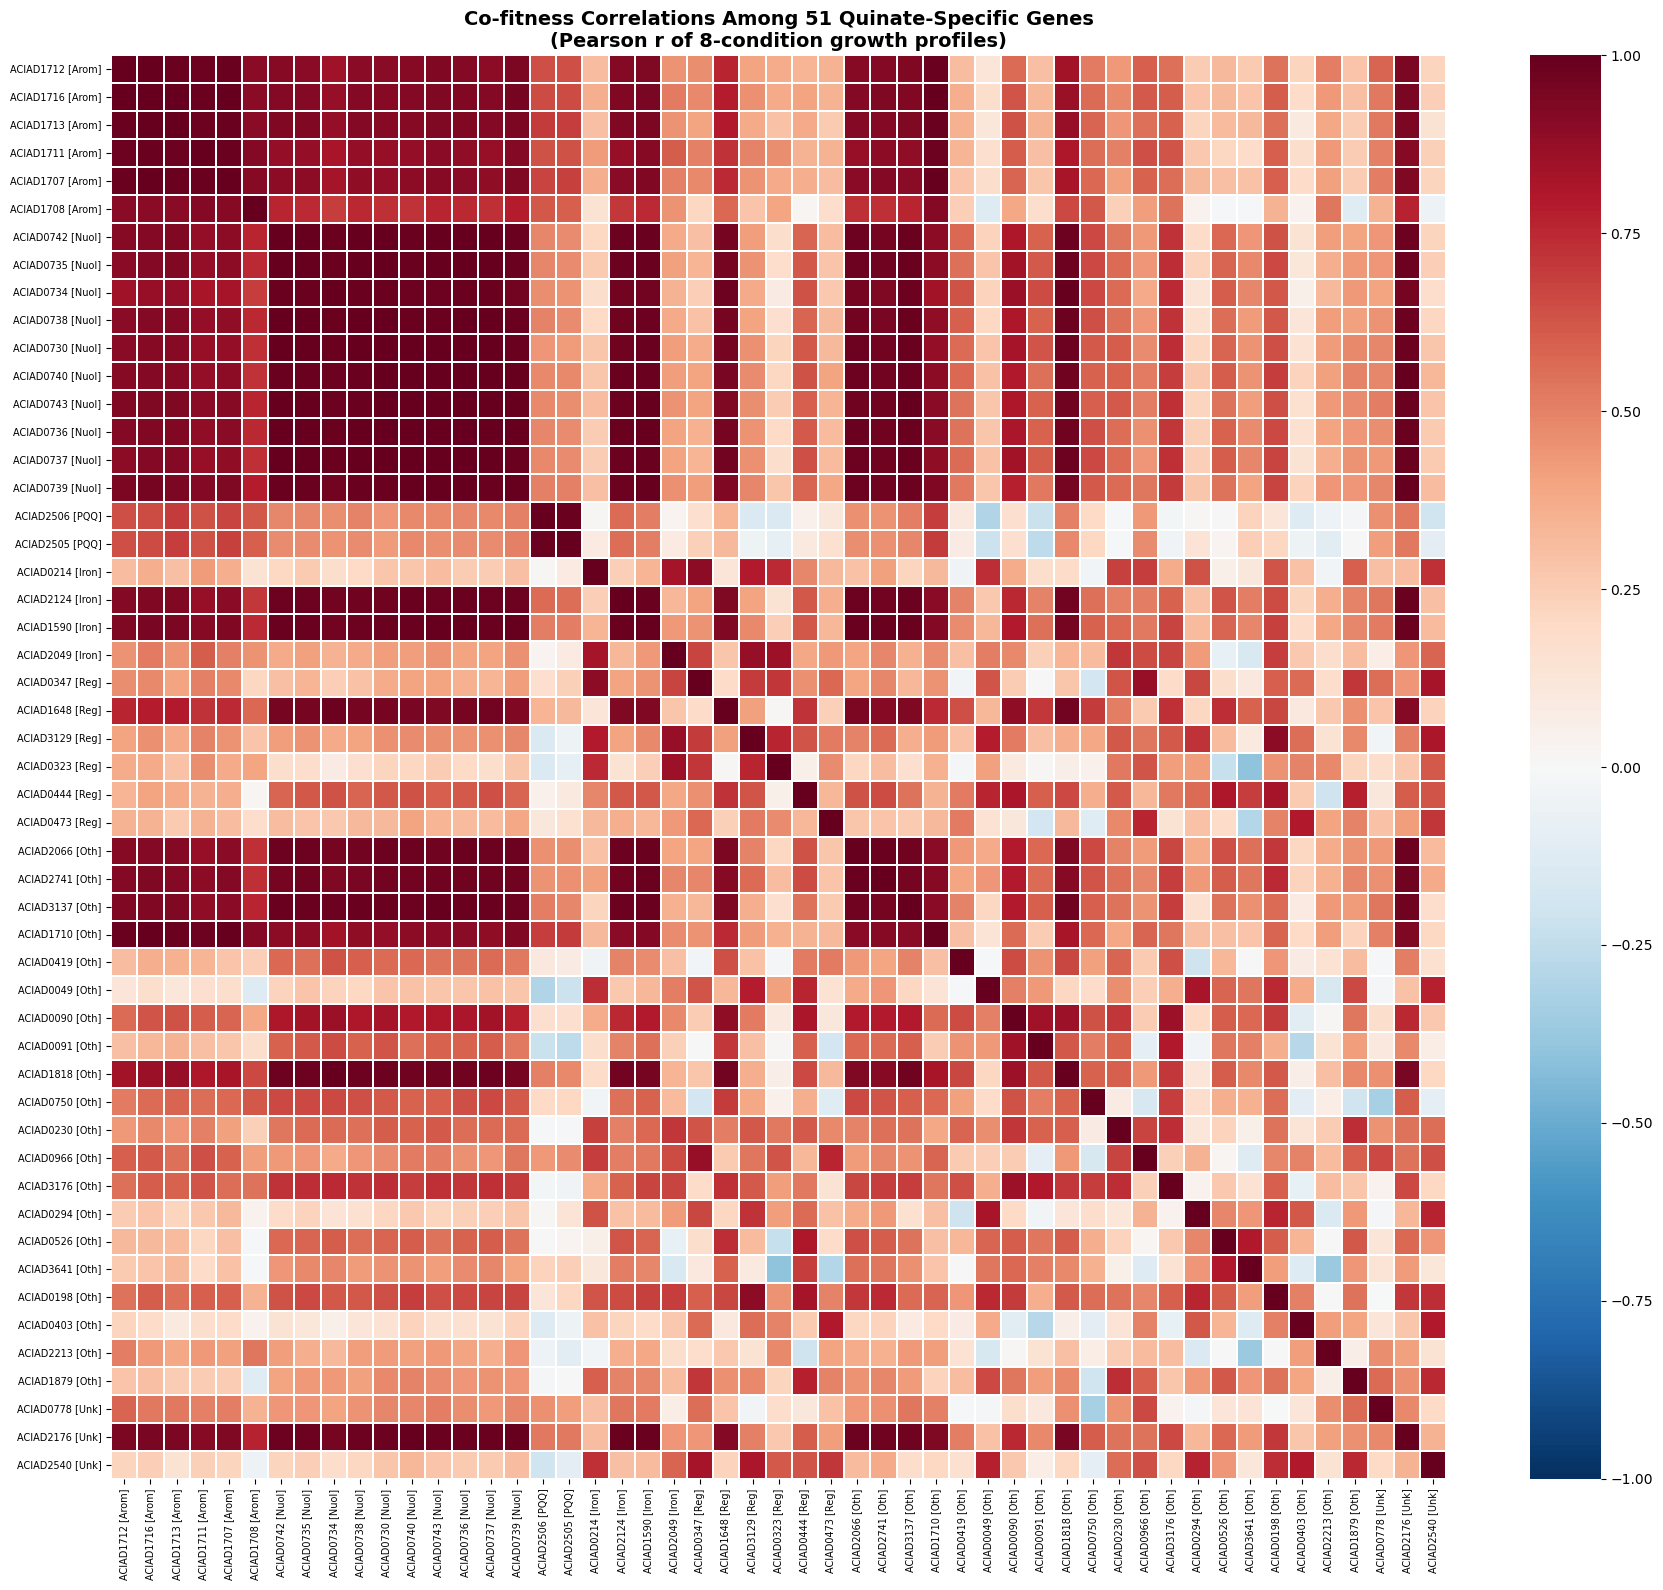

Saved: figures/cofitness_heatmap.png


In [3]:
# Pairwise Pearson correlation among 51 genes
corr_matrix = z_profiles.T.corr()

# Create labels
gene_labels = []
for fid in corr_matrix.index:
    row = qs[qs['feature_id'] == fid].iloc[0]
    locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else fid
    cat_short = {'Aromatic pathway': 'Arom', 'Complex I': 'NuoI', 
                 'PQQ biosynthesis': 'PQQ', 'Iron acquisition': 'Iron',
                 'Regulation': 'Reg', 'Other': 'Oth', 'Unknown': 'Unk'}
    gene_labels.append(f'{locus} [{cat_short.get(row["category"], "?")}]')

# Sort by category for visualization
cat_order = ['Aromatic pathway', 'Complex I', 'PQQ biosynthesis', 'Iron acquisition', 
             'Regulation', 'Other', 'Unknown']
sort_order = qs.set_index('feature_id')['category'].map(
    {c: i for i, c in enumerate(cat_order)}
)
sorted_idx = sort_order.sort_values().index
sorted_labels = [gene_labels[list(corr_matrix.index).index(fid)] for fid in sorted_idx]

corr_sorted = corr_matrix.loc[sorted_idx, sorted_idx]
corr_sorted.index = sorted_labels
corr_sorted.columns = sorted_labels

fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(corr_sorted, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            ax=ax, xticklabels=True, yticklabels=True,
            linewidths=0.1)
ax.set_title('Co-fitness Correlations Among 51 Quinate-Specific Genes\n'
             '(Pearson r of 8-condition growth profiles)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=7, rotation=90)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'cofitness_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/cofitness_heatmap.png')

## 2. Within-Category vs Between-Category Correlations

Do genes in the same functional category have higher co-fitness than genes in different categories?

In [4]:
# Compute within-category and between-category mean correlations
cat_map = qs.set_index('feature_id')['category']

within_corrs = []
between_corrs = []
within_by_cat = {}

for i, g1 in enumerate(corr_matrix.index):
    for j, g2 in enumerate(corr_matrix.columns):
        if i >= j:  # skip diagonal and duplicates
            continue
        r = corr_matrix.iloc[i, j]
        c1, c2 = cat_map[g1], cat_map[g2]
        if c1 == c2:
            within_corrs.append(r)
            within_by_cat.setdefault(c1, []).append(r)
        else:
            between_corrs.append(r)

print('=== Co-fitness: Within vs Between Categories ===')
print(f'Within-category pairs:  n={len(within_corrs):>5}  mean r={np.mean(within_corrs):.3f}  '
      f'median={np.median(within_corrs):.3f}')
print(f'Between-category pairs: n={len(between_corrs):>5}  mean r={np.mean(between_corrs):.3f}  '
      f'median={np.median(between_corrs):.3f}')

print(f'\n=== Within-Category Mean Correlations ===')
for cat in cat_order:
    if cat in within_by_cat:
        vals = within_by_cat[cat]
        print(f'{cat:20s}  n={len(vals):>4}  mean r={np.mean(vals):.3f}  '
              f'median={np.median(vals):.3f}')

=== Co-fitness: Within vs Between Categories ===
Within-category pairs:  n=  275  mean r=0.552  median=0.549
Between-category pairs: n= 1000  mean r=0.518  median=0.497

=== Within-Category Mean Correlations ===
Aromatic pathway      n=  15  mean r=0.961  median=0.985
Complex I             n=  45  mean r=0.992  median=0.994
PQQ biosynthesis      n=   1  mean r=0.991  median=0.991
Iron acquisition      n=   6  mean r=0.529  median=0.389
Regulation            n=  15  mean r=0.453  median=0.475
Other                 n= 190  mean r=0.425  median=0.448
Unknown               n=   3  mean r=0.342  median=0.346


/tmp/ipykernel_10986/479561137.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='type', y='correlation', ax=ax, palette=['steelblue', 'salmon'])


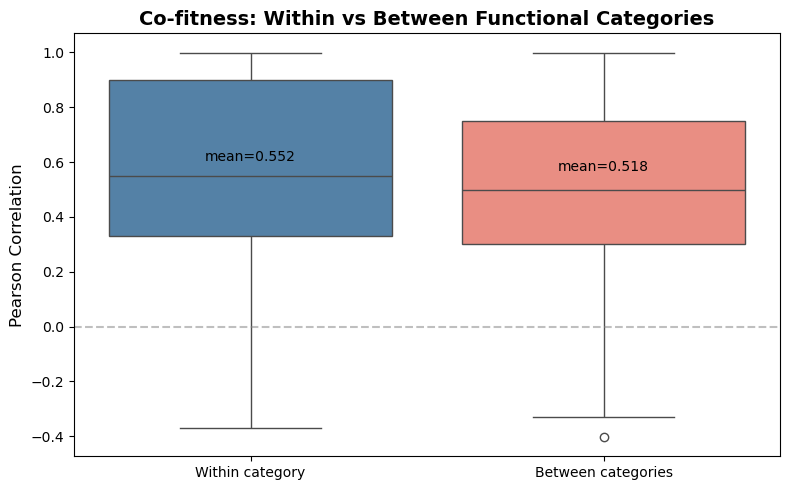

Saved: figures/cofitness_within_between.png


In [5]:
# Box plot: within vs between
fig, ax = plt.subplots(figsize=(8, 5))
data = pd.DataFrame({
    'correlation': within_corrs + between_corrs,
    'type': ['Within category'] * len(within_corrs) + ['Between categories'] * len(between_corrs)
})
sns.boxplot(data=data, x='type', y='correlation', ax=ax, palette=['steelblue', 'salmon'])
ax.axhline(0, color='grey', linestyle='--', alpha=0.5)
ax.set_ylabel('Pearson Correlation', fontsize=12)
ax.set_xlabel('')
ax.set_title('Co-fitness: Within vs Between Functional Categories', fontsize=14, fontweight='bold')

# Add means
for i, (label, vals) in enumerate([('Within', within_corrs), ('Between', between_corrs)]):
    ax.text(i, np.mean(vals) + 0.05, f'mean={np.mean(vals):.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'cofitness_within_between.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/cofitness_within_between.png')

## 3. Assign Unknown/Other Genes to Subsystems

For each of the 24 Other/Unknown genes, compute its mean correlation with each known subsystem. Assign it to the subsystem with highest mean correlation (if above a threshold).

In [6]:
# Known subsystem genes
known_categories = ['Aromatic pathway', 'Complex I', 'PQQ biosynthesis', 'Iron acquisition']
unknown_genes = qs[qs['category'].isin(['Other', 'Unknown'])]['feature_id'].tolist()

print(f'Unknown/Other genes to assign: {len(unknown_genes)}')
print()

# For each unknown gene, compute mean correlation with each known subsystem
assignments = []
for gene_id in unknown_genes:
    row = qs[qs['feature_id'] == gene_id].iloc[0]
    locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else gene_id
    func = row['rast_function'][:45] if pd.notna(row['rast_function']) else '?'
    
    best_cat = None
    best_r = -1
    cat_corrs = {}
    
    for cat in known_categories:
        cat_genes = qs[qs['category'] == cat]['feature_id'].tolist()
        if gene_id in corr_matrix.index:
            corrs = [corr_matrix.loc[gene_id, g] for g in cat_genes if g in corr_matrix.columns]
            if corrs:
                mean_r = np.mean(corrs)
                cat_corrs[cat] = mean_r
                if mean_r > best_r:
                    best_r = mean_r
                    best_cat = cat
    
    assignments.append({
        'feature_id': gene_id,
        'old_locus_tag': locus,
        'rast_function': func,
        'original_category': row['category'],
        'best_match': best_cat,
        'best_mean_r': best_r,
        'r_aromatic': cat_corrs.get('Aromatic pathway', np.nan),
        'r_complex_I': cat_corrs.get('Complex I', np.nan),
        'r_pqq': cat_corrs.get('PQQ biosynthesis', np.nan),
        'r_iron': cat_corrs.get('Iron acquisition', np.nan)
    })

df_assign = pd.DataFrame(assignments).sort_values('best_mean_r', ascending=False)

print('=== Unknown Gene Assignments (by best co-fitness match) ===')
print(f'{"Locus":15s} {"Best Match":20s} {"r":>6s}  {"r_Arom":>6s} {"r_NuoI":>6s} '
      f'{"r_PQQ":>6s} {"r_Iron":>6s}  Function')
print('-' * 110)
for _, row in df_assign.iterrows():
    print(f'{row["old_locus_tag"]:15s} {row["best_match"]:20s} {row["best_mean_r"]:>6.3f}  '
          f'{row["r_aromatic"]:>6.3f} {row["r_complex_I"]:>6.3f} '
          f'{row["r_pqq"]:>6.3f} {row["r_iron"]:>6.3f}  {row["rast_function"]}')

Unknown/Other genes to assign: 23



=== Unknown Gene Assignments (by best co-fitness match) ===
Locus           Best Match                r  r_Arom r_NuoI  r_PQQ r_Iron  Function
--------------------------------------------------------------------------------------------------------------
ACIAD3137       Complex I             0.988   0.890  0.988  0.503  0.635  UPF0234 protein Yitk
ACIAD2176       Complex I             0.983   0.907  0.983  0.527  0.683  DUF2280 domain-containing protein
ACIAD1710       Aromatic pathway      0.978   0.978  0.889  0.698  0.655  4-carboxymuconolactone decarboxylase (EC 4.1.
ACIAD1818       Complex I             0.977   0.810  0.977  0.492  0.612  3-methylmercaptopropionyl-CoA ligase (EC 6.2.
ACIAD2066       Complex I             0.977   0.875  0.977  0.460  0.665  Coenzyme F420-dependent N5,N10-methylene tetr
ACIAD2741       Complex I             0.963   0.884  0.963  0.453  0.712  Phage capsid and scaffold
ACIAD0090       Complex I             0.820   0.567  0.820  0.169  0.600  Glycosyl 

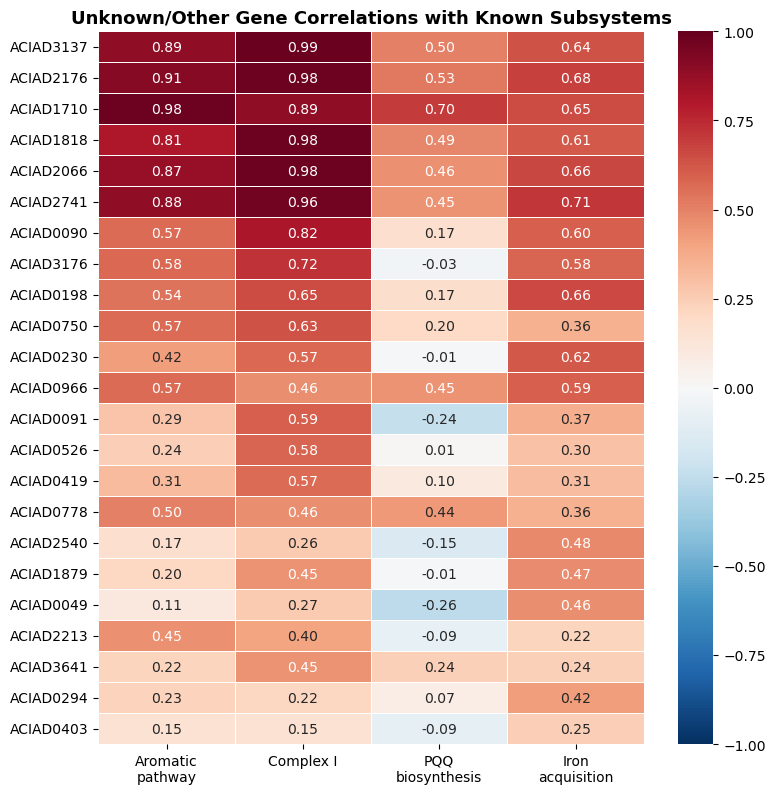

Saved: figures/unknown_assignments_heatmap.png


In [7]:
# Heatmap of unknown gene correlations with each subsystem
assign_data = df_assign[['old_locus_tag', 'r_aromatic', 'r_complex_I', 'r_pqq', 'r_iron']].copy()
assign_data = assign_data.set_index('old_locus_tag')
assign_data.columns = ['Aromatic\npathway', 'Complex I', 'PQQ\nbiosynthesis', 'Iron\nacquisition']

fig, ax = plt.subplots(figsize=(8, max(6, len(assign_data) * 0.35)))
sns.heatmap(assign_data, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            annot=True, fmt='.2f', ax=ax, linewidths=0.5,
            yticklabels=True)
ax.set_title('Unknown/Other Gene Correlations with Known Subsystems',
             fontsize=13, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'unknown_assignments_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/unknown_assignments_heatmap.png')

## 4. Network Summary: Confident Assignments

In [8]:
# Classify assignments by confidence
# High confidence: best_mean_r > 0.7 and clear winner (>0.2 gap to second best)
# Medium confidence: best_mean_r > 0.5
# Low confidence: best_mean_r > 0.3
# Unassigned: best_mean_r <= 0.3

def assign_confidence(row):
    corrs = [row['r_aromatic'], row['r_complex_I'], row['r_pqq'], row['r_iron']]
    corrs_sorted = sorted([c for c in corrs if not np.isnan(c)], reverse=True)
    
    if row['best_mean_r'] > 0.7 and len(corrs_sorted) >= 2 and (corrs_sorted[0] - corrs_sorted[1]) > 0.15:
        return 'High'
    elif row['best_mean_r'] > 0.5:
        return 'Medium'
    elif row['best_mean_r'] > 0.3:
        return 'Low'
    else:
        return 'Unassigned'

df_assign['confidence'] = df_assign.apply(assign_confidence, axis=1)

print('=== Assignment Confidence ===')
print(df_assign['confidence'].value_counts().to_string())
print()

print('=== Confident Assignments (High/Medium) ===')
confident = df_assign[df_assign['confidence'].isin(['High', 'Medium'])]
if len(confident) > 0:
    for _, row in confident.iterrows():
        print(f'  {row["old_locus_tag"]:15s} → {row["best_match"]:20s} (r={row["best_mean_r"]:.3f}, '
              f'{row["confidence"]})  {row["rast_function"]}')
else:
    print('  No high/medium confidence assignments')

print(f'\n=== Summary ===')
print(f'Total unknown/other genes: {len(df_assign)}')
for conf in ['High', 'Medium', 'Low', 'Unassigned']:
    n = (df_assign['confidence'] == conf).sum()
    if n > 0:
        best_matches = df_assign[df_assign['confidence'] == conf]['best_match'].value_counts()
        print(f'  {conf:12s}: {n:>2} genes → {dict(best_matches)}')

=== Assignment Confidence ===
confidence
Medium        14
Low            6
High           2
Unassigned     1

=== Confident Assignments (High/Medium) ===
  ACIAD3137       → Complex I            (r=0.988, Medium)  UPF0234 protein Yitk
  ACIAD2176       → Complex I            (r=0.983, Medium)  DUF2280 domain-containing protein
  ACIAD1710       → Aromatic pathway     (r=0.978, Medium)  4-carboxymuconolactone decarboxylase (EC 4.1.
  ACIAD1818       → Complex I            (r=0.977, High)  3-methylmercaptopropionyl-CoA ligase (EC 6.2.
  ACIAD2066       → Complex I            (r=0.977, Medium)  Coenzyme F420-dependent N5,N10-methylene tetr
  ACIAD2741       → Complex I            (r=0.963, Medium)  Phage capsid and scaffold
  ACIAD0090       → Complex I            (r=0.820, High)  Glycosyl transferase, group 1 family protein
  ACIAD3176       → Complex I            (r=0.723, Medium)  Osmosensitive K+ channel histidine kinase Kdp
  ACIAD0198       → Iron acquisition     (r=0.663, Medium)  

## 5. Updated Support Network Model

In [9]:
# Build final network model
# Combine original categories with confident co-fitness assignments
final_categories = qs[['feature_id', 'old_locus_tag', 'rast_function', 'category']].copy()
final_categories = final_categories.rename(columns={'category': 'original_category'})

# Update with co-fitness assignments for Other/Unknown genes
for _, row in df_assign[df_assign['confidence'].isin(['High', 'Medium'])].iterrows():
    mask = final_categories['feature_id'] == row['feature_id']
    final_categories.loc[mask, 'cofitness_assignment'] = row['best_match']
    final_categories.loc[mask, 'cofitness_confidence'] = row['confidence']
    final_categories.loc[mask, 'cofitness_r'] = row['best_mean_r']

# Final category: use cofitness assignment if available, else original
final_categories['final_category'] = final_categories.apply(
    lambda r: r['cofitness_assignment'] if pd.notna(r.get('cofitness_assignment')) else r['original_category'],
    axis=1
)

print('=== Final Support Network Model ===')
print(f'{"Category":<25s} {"Original":>8s} {"Final":>8s}')
print('-' * 45)
for cat in ['Aromatic pathway', 'Complex I', 'PQQ biosynthesis', 'Iron acquisition',
            'Regulation', 'Other', 'Unknown']:
    n_orig = (final_categories['original_category'] == cat).sum()
    n_final = (final_categories['final_category'] == cat).sum()
    print(f'{cat:<25s} {n_orig:>8d} {n_final:>8d}')

=== Final Support Network Model ===
Category                  Original    Final
---------------------------------------------
Aromatic pathway                 6        8
Complex I                       10       21
PQQ biosynthesis                 2        2
Iron acquisition                 4        7
Regulation                       6        6
Other                           20        6
Unknown                          3        1


In [10]:
# Save results
# Pairwise correlations
corr_long = []
for i, g1 in enumerate(corr_matrix.index):
    for j, g2 in enumerate(corr_matrix.columns):
        if i < j:
            corr_long.append({
                'gene1': g1, 'gene2': g2,
                'pearson_r': corr_matrix.iloc[i, j],
                'cat1': cat_map[g1], 'cat2': cat_map[g2]
            })

pd.DataFrame(corr_long).to_csv(os.path.join(DATA_DIR, 'cofitness_network.csv'), index=False)
print(f'Saved: data/cofitness_network.csv ({len(corr_long)} pairs)')

# Unknown assignments
df_assign.to_csv(os.path.join(DATA_DIR, 'unknown_assignments.csv'), index=False)
print(f'Saved: data/unknown_assignments.csv ({len(df_assign)} genes)')

# Final categories
final_categories.to_csv(os.path.join(DATA_DIR, 'final_network_model.csv'), index=False)
print(f'Saved: data/final_network_model.csv ({len(final_categories)} genes)')

print(f'\n=== NB03 Summary ===')
print(f'Pairwise correlations computed: {len(corr_long)}')
print(f'Within-category mean r: {np.mean(within_corrs):.3f}')
print(f'Between-category mean r: {np.mean(between_corrs):.3f}')
print(f'Unknown genes assigned: {(df_assign["confidence"].isin(["High", "Medium"])).sum()} / {len(df_assign)}')

Saved: data/cofitness_network.csv (1275 pairs)
Saved: data/unknown_assignments.csv (23 genes)
Saved: data/final_network_model.csv (51 genes)

=== NB03 Summary ===
Pairwise correlations computed: 1275
Within-category mean r: 0.552
Between-category mean r: 0.518
Unknown genes assigned: 16 / 23
